Projekt ten ma na celu stworzenie architektury sieci neuronowej oraz wytrenowanie jej wraz z doborem hiperparametrów tak, aby osiągnąć możliwie największe wartości wskazanych metryk.

Wykorzystywany dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10/data

26 191 elementów

In [2]:
# Potrzebne biblioteki

import pathlib
import PIL.Image as Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
import time

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1


In [7]:
!pip install neptune
!pip install neptune-tensorflow-keras

  Obtaining dependency information for neptune from https://files.pythonhosted.org/packages/82/6c/543a4d807cc0b2e03ec50f74d2ddf150903281e3fd5e29d9ff7ac9d0e658/neptune-1.8.5-py3-none-any.whl.metadata
  Obtaining dependency information for boto3>=1.28.0 from https://files.pythonhosted.org/packages/45/78/e95de33d8850429f6740763eb2d5350c02fd39e916f2ddb69fe649d25125/boto3-1.29.6-py3-none-any.whl.metadata
  Obtaining dependency information for botocore<1.33.0,>=1.32.6 from https://files.pythonhosted.org/packages/e4/dd/a6c7154d4f045599ce2df9199c01a8c2650c45ae74ad63f69547a500cc1c/botocore-1.32.6-py3-none-any.whl.metadata
  Obtaining dependency information for s3transfer<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/5a/4b/fec9ce18f8874a96c5061422625ba86c3ee1e6587ccd92ff9f5bf7bd91b2/s3transfer-0.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for bravado-core>=5.16.1 from https://files.pythonhosted.org/packages/5f/26/7fdeaa8b87bbf2a7d05230d4e9f40b232aff4527fe2d582aa

In [8]:
import neptune
from getpass import getpass

api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmNGFlM2E5ZC0zMzgxLTRlZDItYWU2ZC04ODVhNDdmOGMwOWEifQ=="
project= "m.golebiowska556/NNanimals"
project = neptune.init_project(project=project, api_token=api_token)
print(project)

run = neptune.init_run(
    project="m.golebiowska556/NNanimals",
    api_token=api_token,
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

https://app.neptune.ai/m.golebiowska556/NNanimals/
https://app.neptune.ai/m.golebiowska556/NNanimals/e/NNAN-3


# 1. Przygotowanie danych

dict_items([('cavallo', 2623), ('pecora', 1820), ('elefante', 1446), ('gatto', 1668), ('scoiattolo', 1862), ('gallina', 3098), ('ragno', 4821), ('mucca', 1866), ('cane', 4863), ('farfalla', 2112)])


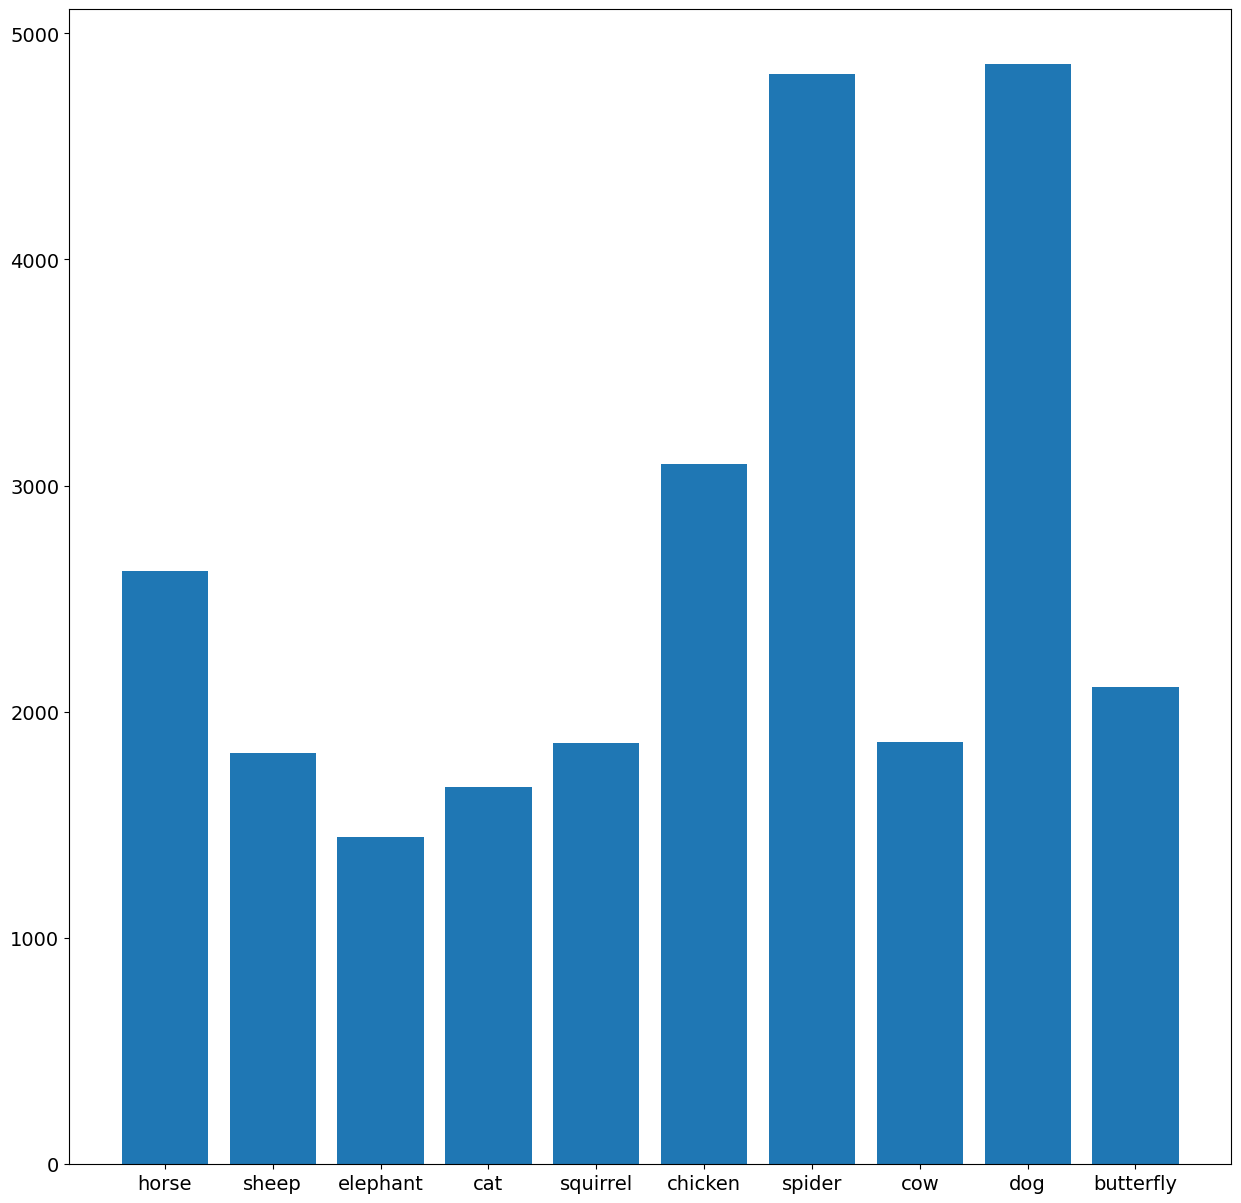

In [11]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/kaggle/input/animals10/raw-img"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))


print(number_of_images.items())
center = []
number_arr = []
label_arr = ['horse','sheep', 'elephant', 'cat', 'squirrel', 'chicken', 'spider', 'cow', 'dog','butterfly']
for label, number in number_of_images.items():
    number_arr.append(number)
    
plt.figure(figsize=(15, 15)) 
plt.bar(label_arr, number_arr)

plt.savefig("/kaggle/working/class_plot.pdf", format="pdf", bbox_inches="tight")

oversampling, undersampling - inb learn
albo ważenie klas

# 3.1 Wybrany model - VGG16

https://www.kaggle.com/code/atishaygwari/transfer-learning-vgg16-93

porownanie naszej, a tej z transfer learningu

intuicyjne parametry, adaptive learning

In [9]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size']=14

In [10]:
img_size=224
batch_size=128
directory='/kaggle/input/animals10/raw-img'

# horizontal flip i zoom

traingen=ImageDataGenerator(rescale=1/255.,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           validation_split=.15)

traindata=traingen.flow_from_directory(directory,
                                       target_size=(img_size,img_size)
                                       ,batch_size=batch_size,
                                       shuffle=True,class_mode='categorical',
                                      subset='training')


valdata=traingen.flow_from_directory(directory,
                                    shuffle=False,batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode="categorical",subset='validation')

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


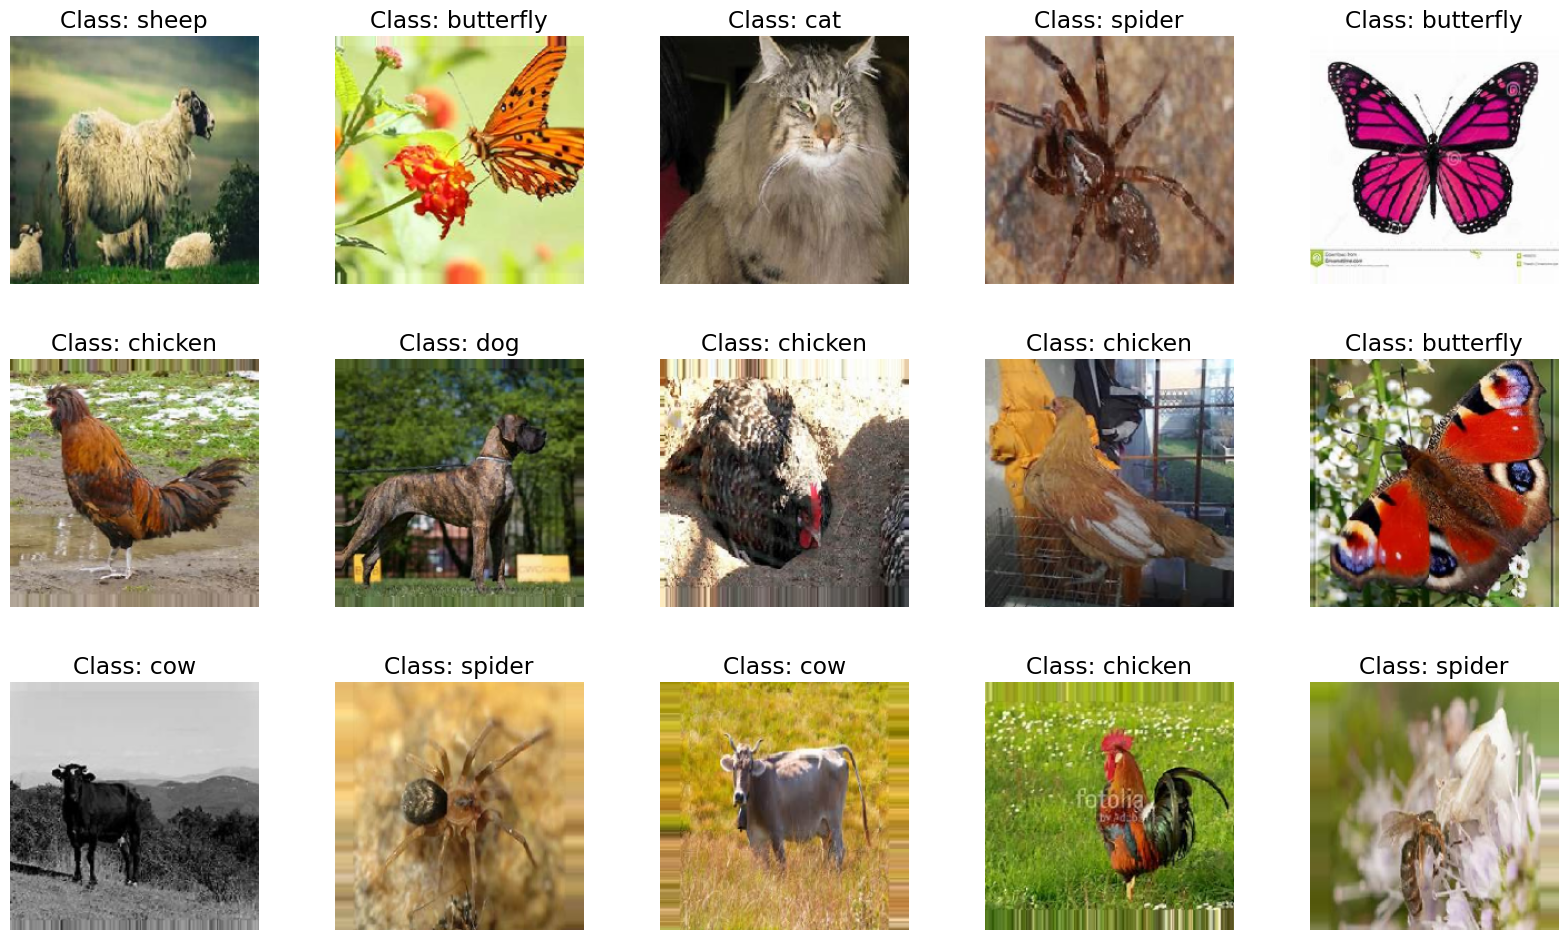

In [14]:
labels = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
samples=traindata.__next__()
images=samples[0]
target=samples[1]
plt.rcParams['figure.figsize']=(20,20)

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[np.argmax(target[i],axis=0)]}")
    plt.axis('off')
    
plt.savefig("/kaggle/working/img_plot.pdf", format="pdf", bbox_inches="tight")

In [11]:
from neptune.integrations.tensorflow_keras import NeptuneCallback
import keras

neptune_cbk = NeptuneCallback(run=run, base_namespace="metrics")

params = {"batch_size": batch_size, "decay_steps": 1000, "initial_learning_rate": 0.01}
run["parameters"] = params

lr_schedule = keras.optimizers.schedules.CosineDecay(
    params["initial_learning_rate"],
    params["decay_steps"],
    alpha=0.0,
    name=None,
    warmup_target=None,
    warmup_steps=0
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
)


In [12]:
# TRANSER LEARNING

model=tf.keras.applications.vgg16.VGG16(include_top=False,
                                             weights='imagenet',
                                             input_shape=(img_size,img_size,3))

model.trainable = False
# base_model.summary()
# # freezujemy 4 ostatnie warstwy modelu
# for layer in model.layers[:-4]:
#     layer.trainable=False

# model.summary()

last_output = model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(128,activation="relu")(x)
x = Dense(512,activation="relu")(x)
outputs = Dense(10,activation="softmax")(x) # zmieniamy na 10 kategorii bo 10 zwierzatek
model = Model(inputs=model.inputs,outputs=outputs)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [32]:
# FROM SCRATCH

model=tf.keras.applications.vgg16.VGG16(weights=None,
                                        input_shape=(img_size,img_size,3),
                                        classes=10)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

Epoch 1/15
174/174 [==============================] - ETA: 0s - loss: 1.1631 - accuracy: 0.5971
Epoch 1: val_loss improved from inf to 0.79215, saving model to VGG.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


174/174 [==============================] - 457s 3s/step - loss: 1.1631 - accuracy: 0.5971 - val_loss: 0.7922 - val_accuracy: 0.7325
Epoch 2/15
174/174 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.7414
Epoch 2: val_loss improved from 0.79215 to 0.67951, saving model to VGG.h5
174/174 [==============================] - 313s 2s/step - loss: 0.7581 - accuracy: 0.7414 - val_loss: 0.6795 - val_accuracy: 0.7677
Epoch 3/15
174/174 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.7746
Epoch 3: val_loss improved from 0.67951 to 0.66976, saving model to VGG.h5
174/174 [==============================] - 312s 2s/step - loss: 0.6606 - accuracy: 0.7746 - val_loss: 0.6698 - val_accuracy: 0.7789
Epoch 4/15
174/174 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.7939
Epoch 4: val_loss improved from 0.66976 to 0.59531, saving model to VGG.h5
174/174 [==============================] - 315s 2s/step - loss: 0.6052 - accuracy: 0.7939 -

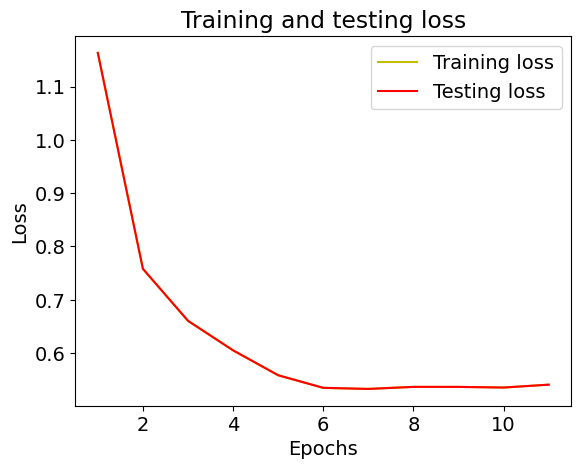

<Figure size 640x480 with 0 Axes>

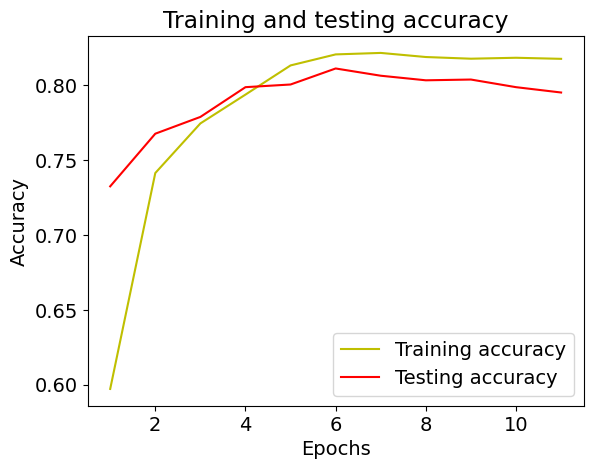

<Figure size 640x480 with 0 Axes>

In [13]:
model_path = "VGG_scratch.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

history = model.fit(traindata,epochs=15,validation_data=valdata,callbacks=[checkpoint,earlystopping, neptune_cbk])

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.savefig("/kaggle/working/loss_plot.pdf", format="pdf", bbox_inches="tight")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig("/kaggle/working/acc_plot.pdf", format="pdf", bbox_inches="tight")


In [14]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/m.golebiowska556/NNanimals/e/NNAN-3/metadata


# 4.1 Wyniki dla VGG

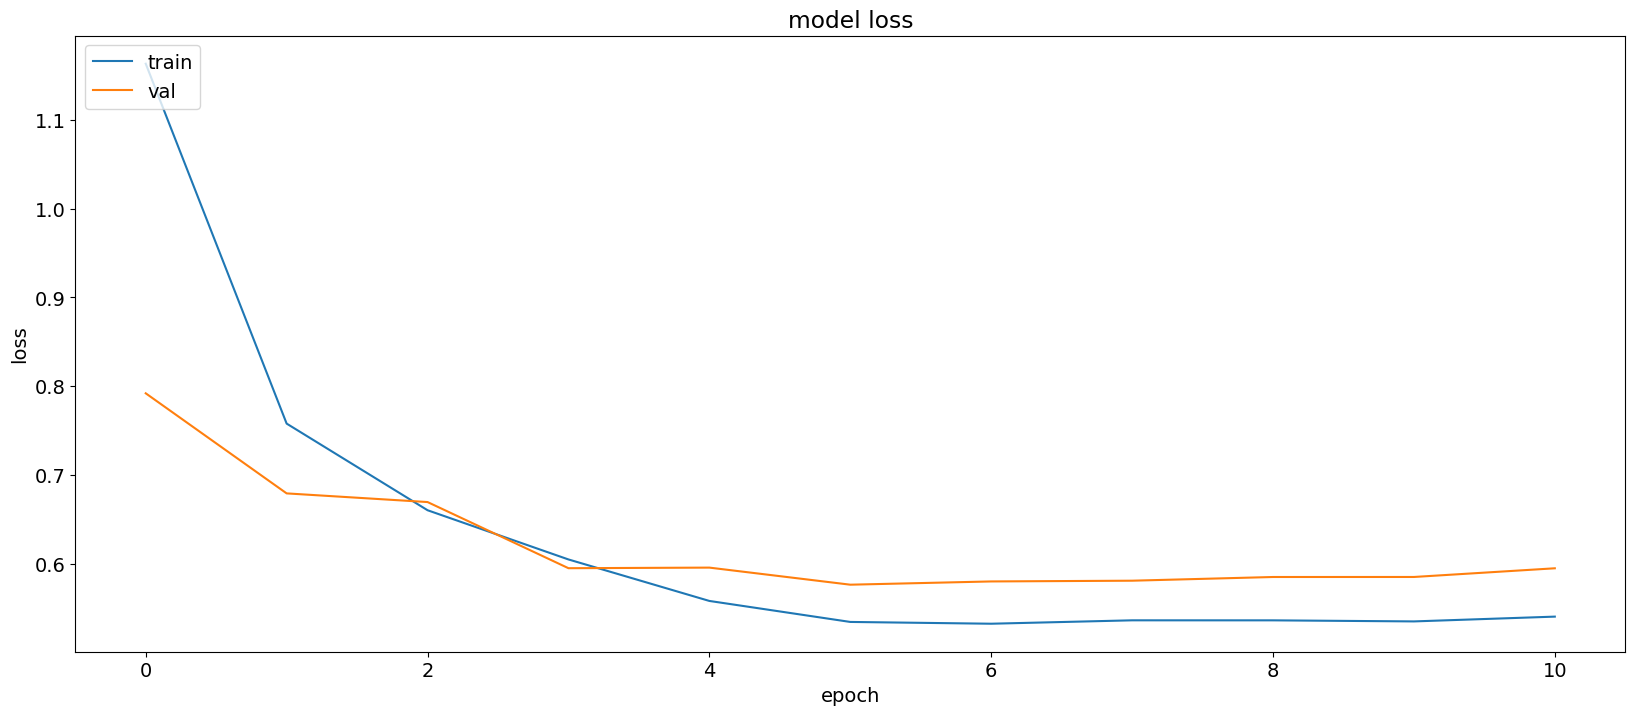

In [15]:
model = tf.keras.models.load_model("/kaggle/working/VGG.h5")

plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
y_test = valdata.classes
y_pred = model.predict(valdata)
y_pred = np.argmax(y_pred,axis=1)

31/31 [==============================] - 45s 1s/step


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

labels = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

y_test = valdata.classes
y_pred = model.predict(valdata)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_test,y_pred,target_names = labels))

31/31 [==============================] - 45s 1s/step
              precision    recall  f1-score   support

         dog       0.80      0.79      0.79       729
       horse       0.78      0.79      0.79       393
    elephant       0.81      0.75      0.78       216
   butterfly       0.92      0.87      0.90       316
     chicken       0.83      0.88      0.85       464
         cat       0.86      0.77      0.81       250
         cow       0.70      0.75      0.73       279
       sheep       0.70      0.65      0.67       273
      spider       0.88      0.92      0.90       723
    squirrel       0.66      0.64      0.65       279

    accuracy                           0.81      3922
   macro avg       0.79      0.78      0.79      3922
weighted avg       0.81      0.81      0.81      3922



In [21]:
scores = model.evaluate(valdata)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

31/31 [==============================] - 45s 1s/step - loss: 0.5871 - accuracy: 0.8001
evaluate accuracy: 80.01%


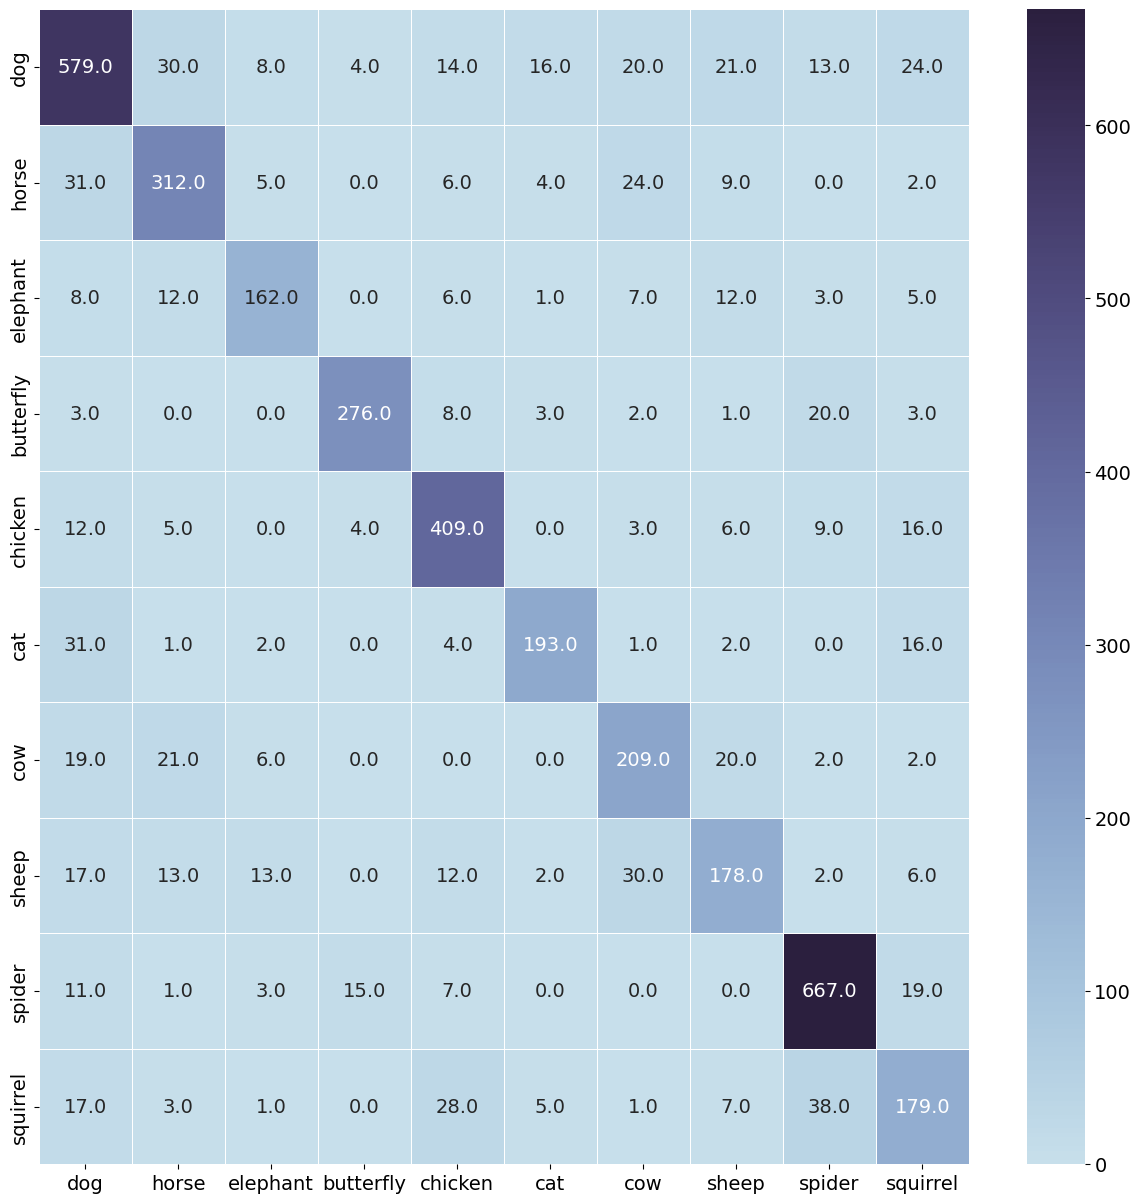

In [31]:
# confusion matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(15, 15)) 
sns.heatmap(cm, annot=True, fmt=".1f", linewidth=.5,
           cmap=sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True),
           xticklabels=labels,  yticklabels=labels)
plt.savefig("/kaggle/working/matrix.pdf", format="pdf", bbox_inches="tight")

# 3.2 Wybrany model - MobileNetV3 / ResNet

też porownanie naszej, a transfer learning

https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

In [ ]:
# nie wszystkie potrzebne
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

In [ ]:
mobile = keras.applications.mobilenet.MobileNet()
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
preprocessed_image = prepare_image('/content/Animals/images/cat/100.jpeg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 1s 549ms/step


[[('n02124075', 'Egyptian_cat', 0.77930963),
  ('n02123045', 'tabby', 0.20108724),
  ('n02123159', 'tiger_cat', 0.018129412),
  ('n02127052', 'lynx', 0.00081075146),
  ('n02119789', 'kit_fox', 0.00013540892)]]